# Wagner-Whitin Problem for DEF Product Ordering

The goal of this exercise is to write code to solve the Wagner-Whitin problem using dynamic programming. CHEMOCO also orders another product, DEF, from a nearby supplier. For that purpose, it uses the Wagner-Whitin model.

## Problem Setup

Currently, the inventory on hand is 70. It is known that reordering costs 2900 euros, while the holding cost is 4 euros per unit per period. The demand for the entire year is estimated using historical averages over the last years. In Table 1, the parameters are summarized and the full data is given in the attached Excel file.

### Parameters

| Parameter              | Value                    | Meaning                        |
|------------------------|--------------------------|--------------------------------|
| K                      | 2900                     | Fixed cost                     |
| h                      | 4                        | Holding cost                   |
| T                      | 52                       | Horizon                        |
| [d1, ..., dT]          | [151, 136, 144, ..., 112, 49, 92] | Forecasted/planned demand     |
| I0                     | 70                       | Initial on-hand inventory      |

**Table 1**: Parameters for the Wagner-Whitin Model.

Can you find the optimal ordering policy for DEF? You may assume lead times are negligible, so ordering the goods in a particular week can immediately fulfill that week's demand. In the slides, we assumed that our `I0 = 0`, but we can modify the case of positive initial inventory (`I0 > 0`) by reducing the demand in `d1` by `I0` units. If `I0 > d1`, then the demand will be reduced in future periods until all `I0` units are accounted for. The first order is placed in the first period with non-zero revised demand, and the optimal cost for the horizon is the θ value for this period. **Note**: This approach assumes the holding cost for the initial inventory units is 0.

## Tasks

### 2a. Optimal Vector of Ordering Decisions

- Provide the optimal vector of ordering decisions, `Q*`, and plot them over the horizon.
- Also, provide the associated total cost.

The Wagner-Whitin problem is often solved on a rolling-horizon basis. In each period, we solve a sub-instance consisting of the current period (say, `t`) through the horizon’s end (say, `t + n − 1`). In the next period, we set `I0` equal to the current on-hand inventory and re-solve the problem, this time for a sub-instance consisting of periods `t + 1` through `t + n`, and so on.

It has been observed that the solution to the Wagner-Whitin problem is "nervous," meaning that when we shift the horizon by one period to create the next sub-instance, the entire solution, throughout the horizon, might change.

### 2b. Check for Nervousness

- Choose a horizon length `n`, for example, 4 weeks (a month) or 12 weeks (a quarter), and check whether your solution is nervous.


In [88]:
import pandas as pd

df = pd.read_excel("Homework_2 (Wagner-Within-instance).xlsx")
K = df["K"].values[0]
h = df["h"].values[0]
T = int(df["T"].values[0])
I_0 = df["I_0"].values[0]
d_t = {t: df[f"d{t}"].values[0] for t in range(1,T+1)}

In [89]:
# Change the demand in the first period to account for the initial inventory
if d_t[1] > I_0:
    d_t[1] -= I_0
    I_0 = 0
elif I_0 > 0:
    i = 1
    while I_0 > 0:
        decrease_with = min(I_0, d_t[i])
        I_0 -= decrease_with
        d_t[i] -= decrease_with


In [90]:
# Initialize theta_{T+1}
import numpy as np


theta = {T+1: 0}
s_t = {}
# Compute theta_t for t = T, T-1, ..., 1
for t in range(T, 0, -1):
    step_two_minimisation = [K + h * sum([(i - t) * d_t[i] for i in range(t, s)]) + theta[s] for s in range(t+1, T+2)]
    theta[t] = min(step_two_minimisation)
    order_until_t = int(np.argmin(step_two_minimisation)) + t
    s_t[t] = order_until_t


# Cost of optimal solution
int(theta[1])

60464

In [91]:
s_t

{52: 52,
 51: 52,
 50: 52,
 49: 52,
 48: 52,
 47: 49,
 46: 49,
 45: 49,
 44: 47,
 43: 47,
 42: 47,
 41: 42,
 40: 42,
 39: 41,
 38: 40,
 37: 40,
 36: 40,
 35: 40,
 34: 36,
 33: 35,
 32: 35,
 31: 34,
 30: 32,
 29: 32,
 28: 30,
 27: 30,
 26: 30,
 25: 30,
 24: 25,
 23: 25,
 22: 25,
 21: 25,
 20: 22,
 19: 22,
 18: 22,
 17: 20,
 16: 20,
 15: 20,
 14: 16,
 13: 16,
 12: 16,
 11: 16,
 10: 12,
 9: 12,
 8: 10,
 7: 10,
 6: 9,
 5: 8,
 4: 8,
 3: 6,
 2: 6,
 1: 3}

In [92]:
Q = {t: 0 for t in range(1, T+1)}
next_s = 1
while next_s < T:
    Q[next_s] = sum([d_t[i] for i in range(next_s, s_t[next_s])])
    if s_t[next_s] >= T:
        Q[next_s] += d_t[T]
        break
    next_s = s_t[next_s]

assert sum(Q.values()) == sum(d_t.values()), "The sum of the orders (Q) and demand (d_t, adjusted for initial inventory) should be equal"
Q

{1: np.int64(217),
 2: 0,
 3: np.int64(230),
 4: 0,
 5: 0,
 6: np.int64(228),
 7: 0,
 8: 0,
 9: np.int64(349),
 10: 0,
 11: 0,
 12: np.int64(378),
 13: 0,
 14: 0,
 15: 0,
 16: np.int64(303),
 17: 0,
 18: 0,
 19: 0,
 20: np.int64(212),
 21: 0,
 22: np.int64(298),
 23: 0,
 24: 0,
 25: np.int64(497),
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: np.int64(186),
 31: 0,
 32: np.int64(279),
 33: 0,
 34: 0,
 35: np.int64(417),
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: np.int64(234),
 41: 0,
 42: np.int64(510),
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: np.int64(113),
 48: 0,
 49: np.int64(297),
 50: 0,
 51: 0,
 52: 0}

Text(0.5, 1.0, 'Inventory levels over time')

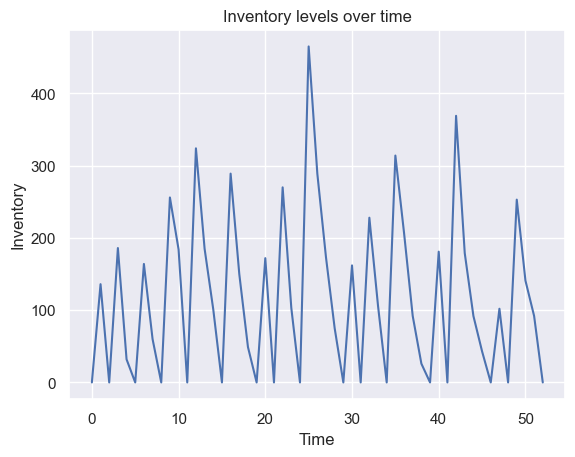

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Plot the inventory levels
inventory = {0: I_0}
for t in range(1, T+1):
    inventory[t] = inventory[t-1] + Q[t] - d_t[t]
sns.lineplot(x=range(T+1), y=list(inventory.values()))
plt.xlabel("Time")
plt.ylabel("Inventory")
plt.title("Inventory levels over time")

In [94]:
# Orders should be placed as follows
{t: int(Q[t]) for t in range(1, T+1) if Q[t] > 0}

{1: 217,
 3: 230,
 6: 228,
 9: 349,
 12: 378,
 16: 303,
 20: 212,
 22: 298,
 25: 497,
 30: 186,
 32: 279,
 35: 417,
 40: 234,
 42: 510,
 47: 113,
 49: 297}